In [372]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Weak Tomography

How to perform weak tomography:

1. Spend half of your time in $Q_0(t)$ which yields information about the diagonal basis.
2. Spend 1/6 of your time in the three bases $e^{\delta L_i}Q_0(t)$ where $i=1,2,3$.

How to decode weak tomography:
    

Note that $L_i$ can be weak rotations around the three axes and that should be enough.

In [330]:
def sensormatrix(L):
    ridx = [0, 4, 8, 1, 2, 5]
    a1 = np.reshape(np.outer(L[:, 0], L[:, 0]), (9,1))[ridx, 0]
    a2 = np.reshape(np.outer(L[:, 1], L[:, 1]), (9,1))[ridx, 0]
    a3 = np.reshape(np.outer(L[:, 2], L[:, 2]), (9,1))[ridx, 0]
    S = np.c_[a1, a2, a3].T
    S[:, 3:6] = 2.0*S[:, 3:6]
    return S

def tomogn(Mval, n):
    mval = 0.5 * (1 - np.diag(Mval))
    T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    Tinv = np.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]])
    pval = np.dot(Tinv, mval)
    pval = np.r_[1-np.sum(pval), pval]
    e = np.random.multinomial(n, pval)
    p = e / float(n)
    Mhat = np.diag(1.0 - 2.0 * np.dot(T, p[1:]))
    return Mhat

def weaktomog(Mval, n=100, d=0.5):
    L1 = np.array([[np.cos(d), -np.sin(d), 0], [np.sin(d), np.cos(d), 0], [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    Mval1 = np.dot(np.dot(L1, Mval), L1.T)
    Mval2 = np.dot(np.dot(L2, Mval), L2.T)
    Mval3 = np.dot(np.dot(L3, Mval), L3.T)
    Mhat1 = tomogn(Mval1, n)
    Mhat2 = tomogn(Mval1, n)
    Mhat3 = tomogn(Mval1, n)
    a = np.r_[np.diag(Mhat1), np.diag(Mhat2), np.diag(Mhat3)].T
    S = np.r_[sensormatrix(L1), sensormatrix(L2), sensormatrix(L3)]
    m = np.linalg.lstsq(S, a)[0]
    M = np.diag(m[0:3])
    M[0, 1], M[0, 2], M[1, 2] = m[3], m[4], m[5]
    M[1, 0], M[2, 0], M[2, 1] = m[3], m[4], m[5]
    return M

In [351]:
ncycles = []
dist = []
Mval_norms = []
Mhat_norms = []
ds = []
for d in [0.05, 0.01, 0.005, 0.0001]:
    for trial in range(100):
        Qval, _ = np.linalg.qr(np.random.random((3,3)))
        Sval = np.diag([0.95, 0.9, 0.85])
        Mval = np.dot(np.dot(Qval, Sval), Qval.T)
        for n in np.logspace(1, 4, 30):
            Mhat = weaktomog(Mval, n=n, d=d)
            dist.append(np.linalg.norm(Mhat - Mval))
            ncycles.append(n)
            Mhat_norms.append(np.linalg.norm(Mhat))
            Mval_norms.append(np.linalg.norm(Mval))
            ds.append(d)

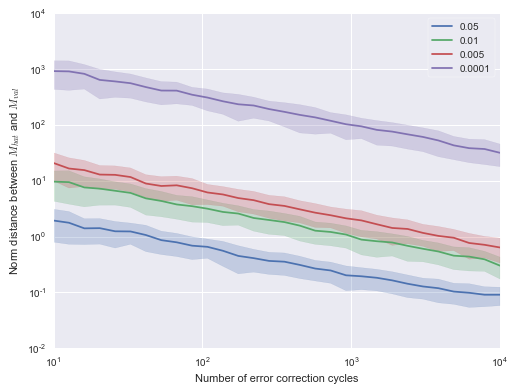

In [379]:
df = pd.DataFrame({"n": ncycles, "dist": dist, "d": ds})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.loglog(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Number of error correction cycles")